## Notebook to revise pyspark and modelling

In this notebook, I am going to load up the [AirBnB San Francisco dataset](https://www.kaggle.com/datasets/jeploretizo/san-francisco-airbnb-listings) in a local spark session and build models to predict the `price` of the AirBnb listing.

##### Premise
It's been a while since I have played around with pyspark and model training. The goal of the notebook is to jog my memory.

##### Environment
- Python 3.10
- Since the goal is to learn, I am running this on my local MacBook Air M1 machine. There will be a different set of problems when running it in a distributed system. See my notes on setting up [databricks with AWS](https://vishnu.uk/blogs/spark-databricks-aws.html).

##### Note to the reader
The [Analysis section](#Analyse-data-to-come-up-with-transformations) section can be safely removed without affecting the rest of the notebook if we are moving this to a script.

### Steps & Notebook sections
### Data loading
- Load data
- Clean data format
- Cast columns to float
- Split data into train and test

### Analyse the data
Here we visualise the distribution of the features. Find features that we might want to log normal. Also look at the frequencies of different categories for categorical variables. We might want to group categories that occur infrequently into an `OTHER` default category. 

### Featurising and transformations
- Build a `pipeline` to featurise the data
    * Transform string columns into one hot encoded columns; take special care to group categories with low frequencies
    * Take $\log$ of features and the label price which are log-normal
- Create `features` column

### Model training
- Train linear regression and xgboost (Gradient boosted trees) models.
- Analyse performance and feature importance.
    * Let's use percentage error in price as final evaluation metric.
    * For linear regression, we can look at model coefficients and their p-values.
    * For xgboost, use the `shap` library to visualise feature importance.

#### Bonus spark work
Create
- Custom Transformer: `LogTransformer`
- `CategoricalDefaultEstimator`: Estimator when applied to a categorical column will convert categories with low frequency to a default value `OTHER` column.


### Learnings
#### ML
- Imputing `null` values with median has a good impact on performance.
- Log normalising several features had little impact on performance.
- Converted categorical variables to OHE with an default `OTHER` category: changing the frequency threshold here had significant impact on final performance.
- XGBoost: hyperparam tuning plays a big role.

#### Spark
- Creating custom transformers in pyspark is not that bad.
- Couldn't find good documentation on creating custom estimators on pyspark, besides a stackoverflow article. Instead simply performed the transformation prior to the modelling pipeline.
- `TrainValidationSplit`, `Pipeline`, `Estimator` and `Transform` interfaces are quite well designed.

#### Hacks

- Couldn't get `shap` working with pyspark's `GBTRegressor`. Struggled with the `CategoricalSplit are not yet implemented error` ([github issue](https://github.com/slundberg/shap/issues/1322)).
- Getting `shap` library required pinning the following packages.
    * `matplotlib==3.6.2`
    * `shap==0.41.0`
    
  Without these the summary plot could not display the colourbar ([github issue](https://github.com/slundberg/shap/issues/2721)).
- Making pyspark work with `xgboost` was also a challenge. For whatever reason, when pyspark was spinning up executor-tasks they weren't packaging `xgboost` correctly. I uninstalled `xgboost` in the virtualenv the notebook was running on. Installed `xgboost` and `sklearn` in the system's default `python3.10` (installed by homebrew). This is ugly but I was running out of patience to debug.


In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
from typing import Optional

import dataclasses
import itertools
import random
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go


import pyspark
import pyspark.ml
import pyspark.ml.util
import pyspark.ml.param.shared
import pyspark.sql
import pyspark.sql.types as T
import pyspark.sql.functions as F
import pandas as pd

from IPython.display import display
from pyspark.ml import feature as spark_feature

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
import pyspark.ml.regression as PSRegression
import pyspark.ml.tuning as PSTuning
import pyspark.ml.evaluation

In [5]:
import xgboost.spark
import shap

In [6]:
spark = pyspark.sql.SparkSession.builder.appName("Spark-learning-2").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/29 14:59:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/29 14:59:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Load data

In [7]:
CHOSEN_COLS = {
    "id",
    "accommodates",
    "bathrooms",
    "bed_type",
    "bedrooms",
    "beds",
    "host_total_listings_count",
    "latitude",
    "longitude",
    "minimum_nights",
    "neighbourhood_cleansed",
    "number_of_reviews",
    "price",
    "property_type",
    "review_scores_accuracy",
    "review_scores_checkin",
    "review_scores_cleanliness",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_rating",
    "review_scores_value",
    "room_type",
}
CHOSEN_COLS_LIST = sorted(CHOSEN_COLS)
CATEGORICAL_COLS = {
    'bed_type',
    'beds',
    'bedrooms',
    'neighbourhood_cleansed',
    'property_type',
    'room_type',
}
CATEGORICAL_COLS_LIST = sorted(CATEGORICAL_COLS)
FLOAT_COLS = {c for c in CHOSEN_COLS if c not in CATEGORICAL_COLS | {'id'}}
FLOAT_COLS_LIST = sorted(FLOAT_COLS)
# Categorical variables with lower than this frequency will be grouped together
# to a default value
CAT_VAR_MIN_THRESH_FRAC = 0.005
DEFAULT_CAT_NAME = '<DEFAULT_CAT>'
LOG_NORM_FEATS = ['host_total_listings_count', 'number_of_reviews', 'price', 'review_scores_value']
LOG_FEATS = [f'log_{c}' for c in LOG_NORM_FEATS]
LABEL_COL = 'log__price'

In [8]:
# Escape option is to parse csv with an escaped json column: [SO](https://stackoverflow.com/a/49313377)
# the column is amenities but we drop it
original_listings_sdf = (
    spark.read
    .option("escape", "\"")
    .option("multiLine", "true")
    .option("ignoreLeadingWhiteSpace", "true")
    .option("ignoreTrailingWhiteSpace", "true")
    .csv("./airbnb-listings.csv", header=True)
).select(*CHOSEN_COLS)

In [9]:
num_rows = original_listings_sdf.count()
print(f"{num_rows=}")

num_rows=8111


##### Convert currency to float

In [10]:
def currency_to_num(curr):
    if curr is None:
        return float('nan')
    # remove space, dollar signe and commas
    return float(re.sub('[\$,\ ]', '',  curr))

currency_to_num_udf = F.udf(currency_to_num, T.DoubleType())

In [11]:
listings_sdf = original_listings_sdf.withColumn(
    "price",
    currency_to_num_udf(F.col("price")),
)
head_df = listings_sdf.limit(2).toPandas()

In [12]:
listings_sdf.select("price").describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|              8111|
|   mean|225.40710146714338|
| stddev|  412.253038691173|
|    min|               0.0|
|    max|           10000.0|
+-------+------------------+



##### Cast stringified float columns to float  

In [13]:
for c in FLOAT_COLS_LIST:
    listings_sdf = listings_sdf.withColumn(c, F.col(c).cast('float'))

#### Loaded data 

In [14]:
print("Schema: ")
pd.DataFrame(
    [
        (s.name, s.dataType, s.nullable)
        for s in listings_sdf.schema
    ]
).transpose()

Schema: 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,room_type,host_total_listings_count,id,review_scores_accuracy,longitude,review_scores_checkin,neighbourhood_cleansed,bedrooms,review_scores_cleanliness,review_scores_communication,property_type,minimum_nights,price,number_of_reviews,beds,bathrooms,review_scores_location,review_scores_value,review_scores_rating,bed_type,latitude,accommodates
1,StringType(),FloatType(),StringType(),FloatType(),FloatType(),FloatType(),StringType(),StringType(),FloatType(),FloatType(),StringType(),FloatType(),FloatType(),FloatType(),StringType(),FloatType(),FloatType(),FloatType(),FloatType(),StringType(),FloatType(),FloatType()
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


##### Example

In [15]:
head_df = listings_sdf.limit(10).toPandas()
head_df.transpose()

,0,1,2,3,4,5,6,7,8,9
room_type,Entire home/apt,Private room,Entire home/apt,Private room,Private room,Entire home/apt,Private room,Private room,Entire home/apt,Entire home/apt
host_total_listings_count,1.0,2.0,2.0,10.0,10.0,2.0,2.0,1.0,1.0,0.0
id,958,3850,5858,7918,8142,8339,8739,9225,10251,10578
review_scores_accuracy,10.0,10.0,10.0,8.0,9.0,10.0,10.0,10.0,10.0,10.0
longitude,-122.433861,-122.458054,-122.421021,-122.452499,-122.451828,-122.436371,-122.422371,-122.405434,-122.413269,-122.415443
review_scores_checkin,10.0,10.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0
neighbourhood_cleansed,Western Addition,Inner Sunset,Bernal Heights,Haight Ashbury,Haight Ashbury,Western Addition,Mission,Potrero Hill,Mission,Nob Hill
bedrooms,1,1,2,1,1,2,1,1,2,0
review_scores_cleanliness,10.0,10.0,10.0,8.0,9.0,10.0,10.0,9.0,10.0,10.0
review_scores_communication,10.0,10.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0


##### Describe data

In [16]:
listings_sdf.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
room_type,8111,None,None,Entire home/apt,Shared room
host_total_listings_count,8103,90.42107861285943,324.52678369427485,0.0,1735.0
id,8111,2.0245608347799286E7,1.2285654207180776E7,10000431,9998879
review_scores_accuracy,6457,9.75220690723246,0.7328724879382621,2.0,10.0
longitude,8111,-122.43010711858047,0.02696715250932219,-122.51306,-122.36857
review_scores_checkin,6456,9.847583643122677,0.5935389673673784,2.0,10.0
neighbourhood_cleansed,8111,None,None,Bayview,Western Addition
bedrooms,8107,1.345873936104601,0.925298245019254,0,8
review_scores_cleanliness,6457,9.603685922254916,0.8397675036579273,2.0,10.0


### Custom estimators and transformers
`LogTransfomer` and `CategoricalDefaultEstimator`.

In [17]:
class LogTransformer(
    pyspark.ml.Transformer,
    pyspark.ml.param.shared.HasInputCols,
    pyspark.ml.param.shared.HasOutputCols,
    pyspark.ml.util.DefaultParamsReadable,
    pyspark.ml.util.DefaultParamsWritable,
):
    
    @pyspark.keyword_only
    def __init__(self, inputCols: list[str], outputCols: Optional[list[str]]=None):
        super(LogTransformer, self).__init__()
        outputCols = outputCols or [f'log__{c}' for c in inputCols]
        self._set(inputCols=inputCols, outputCols=outputCols)

    # Required in Spark >= 3.0
    def setInputCols(self, value):
        """
        Sets the value of :py:attr:`inputCols`.
        """
        return self._set(inputCols=value)
        
        # Required in Spark >= 3.0
    def setOutputCols(self, value):
        """
        Sets the value of :py:attr:`outputCols`.
        """
        return self._set(outputCols=value)
    
    def _transform(self, dataset):
        for ic, oc in zip(self.getInputCols(), self.getOutputCols()):
            dataset = dataset.withColumn(oc, F.log(1 + F.col(ic)))
        return dataset

In [18]:
@dataclasses.dataclass
class CategoricalDefaultEstimator:
    """Estimator when applied to a categorical column
    will convert categories with low frequncy to a 
    default value OTHER column.
    """
    col: str
    freq_thresh: float
    default_cat_name: str = DEFAULT_CAT_NAME
    _new_col: str = dataclasses.field(init=False)
    # A dataframe with two cols `{col}, new_{col}`
    # with old column values and new column values
    _colval_mapping_sdf: pyspark.sql.DataFrame = dataclasses.field(init=False)
        
    def __post_init__(self):
        self._new_col = f'new_{self.col}'

    def fit(self, training_sdf) -> 'CategoricalDefaultEstimator':
        self._colval_mapping_sdf = _group_low_freq_cat_vals(
            sdf=training_sdf,
            col=self.col,
            new_col=self._new_col,
            freq_thresh=self.freq_thresh,
            default_cat_name=self.default_cat_name,
        )
        return self
    
    def transform(self, sdf) -> pyspark.sql.DataFrame:
        return _remap_col_vals(
            sdf=sdf,
            col=self.col,
            new_col=self._new_col,
            colval_mapping_sdf=self._colval_mapping_sdf,
            default_cat_name=self.default_cat_name,
        )


def _group_low_freq_cat_vals(
    sdf,
    col,
    new_col,
    freq_thresh,
    default_cat_name,
    null_default='NA',
) -> pyspark.sql.DataFrame:
    """Takes a categorical variable column. Finds categorical
    values occurring below a threshold freq and assigns them to a
    default categorical label.
    
    Output dataframe::
    """
    column_count_sdf = (
        sdf
        .select(col)
        # We need to remap null to a string so that when the
        # output mapping gets joined with the table being transformed
        # we actually join on values with None.
        .fillna(value=null_default)
        .groupBy(col)
        .count()
        .orderBy(F.col(col).asc())
    )
    min_cat_var_count = int(freq_thresh * sdf.count())
    print(
        f'[Column: {col}] {freq_thresh=:.0%}, Counts below this'
        f' will be made default category: {min_cat_var_count:,}'
    )
    map_sdf = column_count_sdf.withColumn(
        new_col,
        (
            F.when(F.col('count') >= min_cat_var_count, F.col(col))
            .otherwise(default_cat_name)
        )
    ).select(col, new_col)
    num_dflted_cat_vals = map_sdf.filter(F.col(new_col)==default_cat_name).count()
    print(
        f'[Column : {col}] Number of categories'
        f' set to default {default_cat_name}: {num_dflted_cat_vals:,}\n'
    )
    return map_sdf


def _remap_col_vals(
    sdf,
    col,
    new_col,
    colval_mapping_sdf,
    default_cat_name,
    null_default='NA',
):
    return (
        sdf
        # If we don't add this the columns with value None are not
        # merged. The same default should have been applied in the
        # `colval_mapping_sdf`
        .fillna(value=null_default, subset=[col])
        .join(other=colval_mapping_sdf, on=col, how='left_outer')
        # If we find a category in the DF column being transformed that
        # did not appear in the `colval_mapping_sdf` then this must
        # be a rare category and we should set it to the default category.
        .fillna(value=default_cat_name, subset=[new_col])
        .drop(col)
        .withColumnRenamed(new_col, col)
    )

## Train test split our dataset

In [19]:
training_sdf, test_sdf = listings_sdf.randomSplit(weights=[0.75,0.25], seed=42)

In [20]:
print(f"{training_sdf.count()=}, {test_sdf.count()=}")

training_sdf.count()=6155, test_sdf.count()=1956


## Analyse data to come up with transformations

In [21]:
# Create a copy of the training dataframe to play around with
tmp_train_sdf = training_sdf.alias("training_tmp_sdf")

### Histograms of numerical features

In [22]:
sample_df = (
    tmp_train_sdf
    .sample(withReplacement=False, fraction=1000/num_rows)
).toPandas()

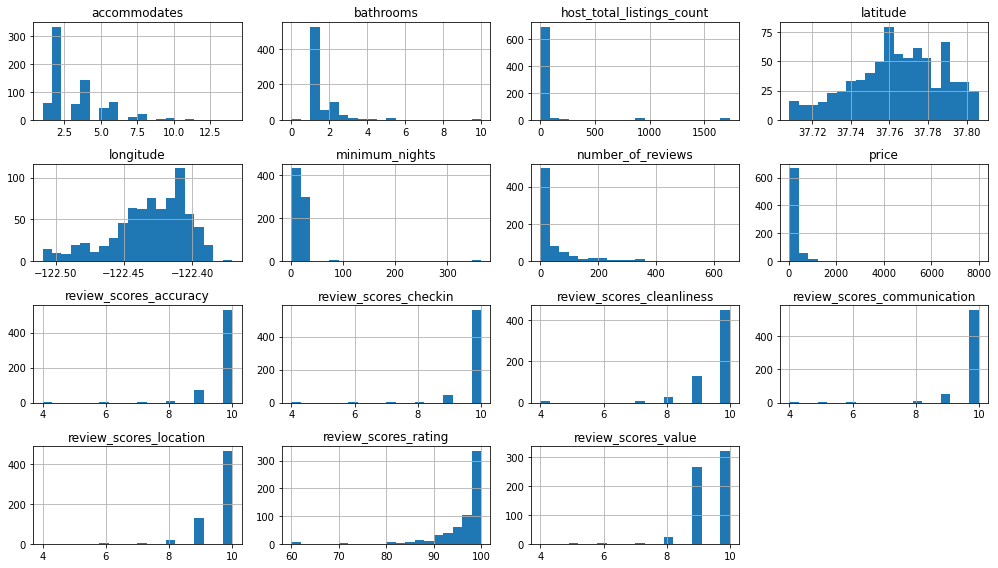

In [23]:
hist_kwargs = dict(figsize=(14,8), bins=20)
_ = sample_df[FLOAT_COLS_LIST].hist(**hist_kwargs)
plt.tight_layout()

In [24]:
tmp_train_sdf.groupBy("bathrooms").count().orderBy(F.col('count').desc()).show()

+---------+-----+
|bathrooms|count|
+---------+-----+
|      1.0| 4302|
|      2.0|  863|
|      1.5|  433|
|      2.5|  176|
|      3.0|  110|
|      5.0|   77|
|      4.0|   53|
|      3.5|   49|
|      0.0|   25|
|     10.0|   14|
|      0.5|   14|
|      8.0|   11|
|      4.5|    9|
|      6.0|    8|
|     null|    7|
|      7.0|    2|
|     14.0|    1|
|      6.5|    1|
+---------+-----+



#### USEFUL OBSERVATION
It's clear that for all intents and purposes the following columns behave like categorical variables

- accommodates
- beds
- minimum_nights
- review_scores_communication
- review_scores_accuracy
- review_scores_checkin
- review_scores_cleanliness
- review_scores_scores_communication
- review_scores_rating


In [25]:
print(f"Features that seem to have a log normal distribution: \n{LOG_NORM_FEATS}")

Features that seem to have a log normal distribution: 
['host_total_listings_count', 'number_of_reviews', 'price', 'review_scores_value']


In [26]:
def add_log_normal_cols(log_norm_feats, log_feat_names, sdf):
    for c, new_c in zip(log_norm_feats, log_feat_names):
        sdf = (
            sdf
            .withColumn(new_c, F.log(1 + F.col(c)))
        )
    return sdf

tmp_train_sdf = add_log_normal_cols(sdf=tmp_train_sdf, log_norm_feats=LOG_NORM_FEATS, log_feat_names=LOG_FEATS)

#### Plot log-normal features after applying $\log$

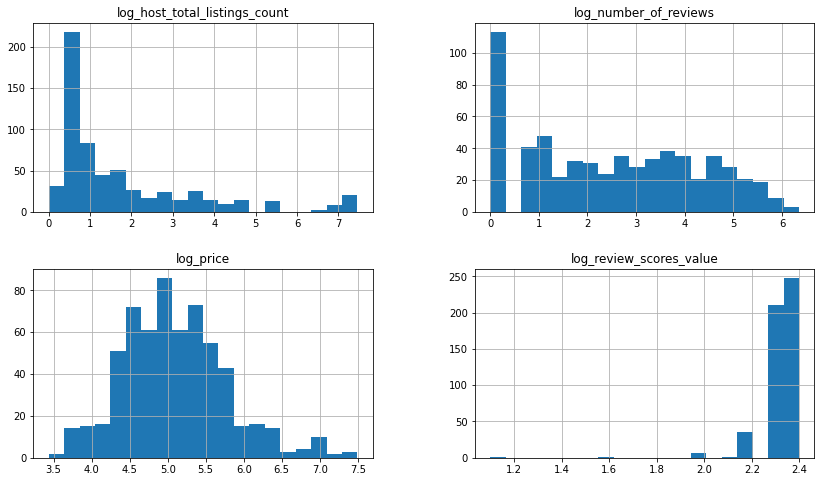

In [27]:
_ = tmp_train_sdf.select(*LOG_FEATS).sample(0.1).toPandas().hist(**hist_kwargs)

### Look at the distribution of categorical features

#### Unique values of string columns

In [28]:
distinct_vals_sdfs = [
    tmp_train_sdf.select(c).distinct().select(F.monotonically_increasing_id().alias('id'), c)
    for c in CATEGORICAL_COLS_LIST
]
distinct_sdf = distinct_vals_sdfs[0]
for sdf in distinct_vals_sdfs[1:]:
    distinct_sdf = distinct_sdf.join(other=sdf, on='id', how='outer')
distinct_sdf.toPandas().drop(['id'],axis=1)

,bed_type,bedrooms,beds,neighbourhood_cleansed,property_type,room_type
0,Airbed,7,7,Inner Sunset,Apartment,Shared room
1,Futon,3,3,Haight Ashbury,Townhouse,Hotel room
2,Pull-out Sofa,8,8,Financial District,Resort,Entire home/apt
3,Couch,0,0,Treasure Island/YBI,Guest suite,Private room
4,Real Bed,None,None,North Beach,Dome house,None
5,None,5,5,Western Addition,Camper/RV,None
6,None,6,6,Downtown/Civic Center,Boutique hotel,None
7,None,1,9,Bernal Heights,Castle,None
8,None,4,1,Lakeshore,Loft,None
9,None,14,10,Outer Sunset,Guesthouse,None


#### Frequency of categorical values

In [29]:
def print_cnts_by_cols(sdf, cols):
    for c in cols:
        display(
            sdf
            .groupBy(c)
            .count()
            .orderBy(F.col('count').desc())
            .withColumnRenamed('count', f'{c}_count')
            .toPandas()
        )
    
print_cnts_by_cols(sdf=tmp_train_sdf, cols=CATEGORICAL_COLS_LIST)

,bed_type,bed_type_count
0,Real Bed,6103
1,Futon,22
2,Pull-out Sofa,15
3,Airbed,10
4,Couch,5


,bedrooms,bedrooms_count
0,1,3685
1,2,1143
2,0,621
3,3,516
4,4,150
5,5,27
6,6,7
7,None,3
8,7,1
9,8,1


,beds,beds_count
0,1,3346
1,2,1571
2,3,616
3,4,325
4,5,124
5,0,92
6,6,34
7,7,26
8,None,8
9,8,7


,neighbourhood_cleansed,neighbourhood_cleansed_count
0,Mission,562
1,South of Market,520
2,Downtown/Civic Center,505
3,Western Addition,473
4,Castro/Upper Market,340
5,Haight Ashbury,311
6,Bernal Heights,308
7,Noe Valley,258
8,Nob Hill,234
9,Outer Sunset,213


,property_type,property_type_count
0,Apartment,2456
1,House,1760
2,Condominium,688
3,Guest suite,437
4,Boutique hotel,204
5,Hotel,117
6,Townhouse,103
7,Serviced apartment,89
8,Hostel,68
9,Loft,67


,room_type,room_type_count
0,Entire home/apt,3627
1,Private room,2187
2,Shared room,178
3,Hotel room,163


#### Look at which categories survive after bucketing low frequency categories into `<DEFAULT_CAT>`.

In [30]:
num_rows_training = tmp_train_sdf.count()

In [31]:
min_cat_var_count = int(num_rows_training * CAT_VAR_MIN_THRESH_FRAC)
print(f"{num_rows=}\t{min_cat_var_count=}\t{CAT_VAR_MIN_THRESH_FRAC=:.2%}")

num_rows=8111	min_cat_var_count=30	CAT_VAR_MIN_THRESH_FRAC=0.50%


In [32]:
tmp2_train_sdf = tmp_train_sdf.alias('train2_sdf')
for c in CATEGORICAL_COLS_LIST:
    tmp2_train_sdf = CategoricalDefaultEstimator(
        col=c, freq_thresh=CAT_VAR_MIN_THRESH_FRAC
    ).fit(
        training_sdf=tmp2_train_sdf,
    ).transform(
        sdf=tmp2_train_sdf,
    )
print_cnts_by_cols(sdf=tmp2_train_sdf, cols=CATEGORICAL_COLS_LIST)

[Column: bed_type] freq_thresh=0%, Counts below this will be made default category: 30
[Column : bed_type] Number of categories set to default <DEFAULT_CAT>: 4

[Column: bedrooms] freq_thresh=0%, Counts below this will be made default category: 30
[Column : bedrooms] Number of categories set to default <DEFAULT_CAT>: 6

[Column: beds] freq_thresh=0%, Counts below this will be made default category: 30
[Column : beds] Number of categories set to default <DEFAULT_CAT>: 6

[Column: neighbourhood_cleansed] freq_thresh=0%, Counts below this will be made default category: 30
[Column : neighbourhood_cleansed] Number of categories set to default <DEFAULT_CAT>: 6

[Column: property_type] freq_thresh=0%, Counts below this will be made default category: 30
[Column : property_type] Number of categories set to default <DEFAULT_CAT>: 11

[Column: room_type] freq_thresh=0%, Counts below this will be made default category: 30
[Column : room_type] Number of categories set to default <DEFAULT_CAT>: 0



,bed_type,bed_type_count
0,Real Bed,6103
1,<DEFAULT_CAT>,52


,bedrooms,bedrooms_count
0,1,3685
1,2,1143
2,0,621
3,3,516
4,4,150
5,<DEFAULT_CAT>,40


,beds,beds_count
0,1,3346
1,2,1571
2,3,616
3,4,325
4,5,124
5,0,92
6,<DEFAULT_CAT>,47
7,6,34


,neighbourhood_cleansed,neighbourhood_cleansed_count
0,Mission,562
1,South of Market,520
2,Downtown/Civic Center,505
3,Western Addition,473
4,Castro/Upper Market,340
5,Haight Ashbury,311
6,Bernal Heights,308
7,Noe Valley,258
8,Nob Hill,234
9,Outer Sunset,213


,property_type,property_type_count
0,Apartment,2456
1,House,1760
2,Condominium,688
3,Guest suite,437
4,Boutique hotel,204
5,Hotel,117
6,Townhouse,103
7,Serviced apartment,89
8,<DEFAULT_CAT>,70
9,Hostel,68


,room_type,room_type_count
0,Entire home/apt,3627
1,Private room,2187
2,Shared room,178
3,Hotel room,163


### Conclusions
Transformations we should do:
1. log normalise: `'host_total_listings_count', 'number_of_reviews', 'price', 'review_scores_value'`
2. convert low freq cols in cats to default as above.

## Featurise

The output of this section would be a transformation `Pipeline` which takes in a dataframe and adds features column.

### For categorical columns values which appear rarely set them to default values

#### Build default value transformer

In [33]:
categ_default_estim_list = [
    CategoricalDefaultEstimator(
        col=c, freq_thresh=CAT_VAR_MIN_THRESH_FRAC
    ).fit(
        training_sdf=training_sdf,
    )
    for c in CATEGORICAL_COLS_LIST
]

[Column: bed_type] freq_thresh=0%, Counts below this will be made default category: 30
[Column : bed_type] Number of categories set to default <DEFAULT_CAT>: 4

[Column: bedrooms] freq_thresh=0%, Counts below this will be made default category: 30
[Column : bedrooms] Number of categories set to default <DEFAULT_CAT>: 6

[Column: beds] freq_thresh=0%, Counts below this will be made default category: 30
[Column : beds] Number of categories set to default <DEFAULT_CAT>: 6

[Column: neighbourhood_cleansed] freq_thresh=0%, Counts below this will be made default category: 30
[Column : neighbourhood_cleansed] Number of categories set to default <DEFAULT_CAT>: 6

[Column: property_type] freq_thresh=0%, Counts below this will be made default category: 30
[Column : property_type] Number of categories set to default <DEFAULT_CAT>: 11

[Column: room_type] freq_thresh=0%, Counts below this will be made default category: 30
[Column : room_type] Number of categories set to default <DEFAULT_CAT>: 0



#### Transform categorical columns in train and test

**NOTE:** This is ugly because we are mutating our train and test split instead of doing this in a pipeline. But creating custom estimators is a pain in pyspark so 🤷

In [34]:
train_mod_sdf = training_sdf.alias('train_mod')
test_mod_sdf = test_sdf.alias('test_mod')

for cde in categ_default_estim_list:
    train_mod_sdf = cde.transform(sdf=train_mod_sdf)
    test_mod_sdf = cde.transform(sdf=test_mod_sdf)    

In [35]:
col = random.choice(CATEGORICAL_COLS_LIST)
train_mod_sdf.groupby(col).count().show()
test_mod_sdf.groupby(col).count().show()

+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|          Inner Sunset|  137|
|        Haight Ashbury|  311|
|    Financial District|  137|
|           North Beach|  129|
|      Western Addition|  473|
|  Downtown/Civic Ce...|  505|
|        Bernal Heights|  308|
|             Lakeshore|   53|
|          Outer Sunset|  213|
|     Visitacion Valley|   67|
|        Inner Richmond|  161|
|              Nob Hill|  234|
|        Outer Richmond|  134|
|        Crocker Amazon|   39|
|               Bayview|  155|
|             Chinatown|   93|
|               Mission|  562|
|             Excelsior|  137|
|            Twin Peaks|   51|
|             Glen Park|   47|
+----------------------+-----+
only showing top 20 rows

+----------------------+-----+
|neighbourhood_cleansed|count|
+----------------------+-----+
|          Inner Sunset|   36|
|        Haight Ashbury|   87|
|    Financial District|   46|
|           North Beach|   44|
|      Wester

##### Create a custom log value transformer

In [36]:
LogTransformer(inputCols=['price', 'review_scores_value']).transform(dataset=train_mod_sdf).select(
    'price', 'log__price', 'review_scores_value', 'log__review_scores_value'
).limit(10).toPandas()

,price,log__price,review_scores_value,log__review_scores_value
0,345.0,5.846439,9.0,2.302585
1,120.0,4.795791,10.0,2.397895
2,160.0,5.081404,10.0,2.397895
3,159.0,5.075174,9.0,2.302585
4,301.0,5.710427,9.0,2.302585
5,132.0,4.890349,10.0,2.397895
6,295.0,5.690359,10.0,2.397895
7,96.0,4.574711,9.0,2.302585
8,195.0,5.278115,10.0,2.397895
9,125.0,4.836282,9.0,2.302585


### Create a Pipeline functions
These are `pyspark` `Transfomers` and `Estimators` such as `StringIndexer` and `OneHotEncoder`. 

In [37]:
FEATURES = [
    "vec__bed_type",
    "vec__bedrooms",
    'vec__beds',
    "vec__neighbourhood_cleansed",
    "vec__property_type",
    "vec__room_type",
    
    "log__host_total_listings_count",
    "log__number_of_reviews",
    "log__review_scores_value",
    
    "accommodates",
    "bathrooms",
    "latitude",
    "longitude",
    "minimum_nights",
    "review_scores_accuracy",
    "review_scores_checkin",
    "review_scores_cleanliness",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_rating",
]
NON_VECTOR_FEAT_COLS = [f for f in FEATURES if not f.startswith('vec')]

In [38]:
string_indexer = spark_feature.StringIndexer(
    inputCols=CATEGORICAL_COLS_LIST,
    outputCols=[f'index__{c}' for c in CATEGORICAL_COLS_LIST]
)
common_featurisation_stages = [
    LogTransformer(inputCols=LOG_NORM_FEATS),
    string_indexer,
    spark_feature.OneHotEncoder(
        inputCols=string_indexer.getOutputCols(),
        outputCols=[f'vec__{c}' for c in CATEGORICAL_COLS_LIST]
    ),
]
imputer = spark_feature.Imputer(
    strategy='median',
    inputCols=NON_VECTOR_FEAT_COLS,
    outputCols=NON_VECTOR_FEAT_COLS,
)
assembler = spark_feature.VectorAssembler(inputCols=FEATURES, outputCol='features',handleInvalid='keep')
evaluator = pyspark.ml.evaluation.RegressionEvaluator(
    labelCol=LABEL_COL,
    metricName='mae',
)

## Model training

Use the feature pipeline above to train a linear regression and xgboost model.

### Custom Model metrics functions
These compute the average percentage error in predicting price of the AirBnB listing.

In [39]:
def avg_percent_error(tvs_model, sdf):
    sdf = tvs_model.bestModel.transform(sdf).select('log__price', 'prediction')
    sdf = (
        sdf
        .withColumn('price', F.exp('log__price')-1)
        .withColumn('predicted_price', F.exp('prediction')-1)
        .withColumn('percent_error', F.abs(F.col('price')-F.col('predicted_price'))/F.col('price') * 100.)
    )
    display(sdf.limit(4).toPandas())
    display(sdf.select('percent_error').describe().toPandas())
    avg_error = sdf.select(F.mean('percent_error').alias('err')).collect()[0].err
    return {'error_df': sdf, 'avg_percent_error': avg_error}


def print_train_test_error(tvs_model, train_sdf, test_sdf, model_name=''):
    for sdf, split in [(train_sdf, 'train'), (test_sdf, 'test')]:
        error_df = avg_percent_error(tvs_model=tvs_model, sdf=sdf)
        print(
            f'\n[{model_name}] Average percent error on {split} '
            f'dataset: {error_df["avg_percent_error"]:.0f}%\n\n'
        )


### Linear regression

In [40]:
lr_feat_pipeline = pyspark.ml.Pipeline(
    stages=(
        common_featurisation_stages
        + [imputer, assembler]
    ),
)

In [41]:
lr = PSRegression.LinearRegression(featuresCol='features', labelCol=LABEL_COL, elasticNetParam=0.01, regParam=0.01)
lr_pipeline = pyspark.ml.Pipeline(stages=[lr_feat_pipeline, lr])

In [42]:
param_grid = (
    PSTuning.ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.001])
    .addGrid(lr.elasticNetParam, [0.3, 0.4])
    .build() 
)

In [43]:
tvs_lr = PSTuning.TrainValidationSplit(
    estimator=lr_pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8,
)

In [44]:
lr_tvs_model = tvs_lr.fit(train_mod_sdf)

22/11/29 15:00:20 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/11/29 15:00:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/29 15:00:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


#### Feature importance

In [45]:
lr_tvs_model.bestModel.stages[-1].coefficients

DenseVector([0.0, -0.182, 0.0, -0.3508, 0.1765, 0.2546, 0.0, 0.0, -0.0016, 0.0, 0.0, -0.0198, -0.0482, 0.0412, 0.1383, -0.0325, 0.004, 0.0882, 0.0, 0.0, 0.0823, 0.0, -0.1305, 0.0626, -0.0834, 0.0, -0.1871, -0.187, 0.0308, -0.011, 0.0, -0.1754, 0.0, 0.0166, 0.1009, 0.0, -0.0812, -0.045, -0.0625, -0.0433, 0.0187, 0.0709, 0.0, 0.0356, -0.0686, 0.0, 0.0329, -0.0372, 0.4778, 0.3855, 0.0, -0.0024, 0.2229, -0.2585, 0.1529, -0.074, 0.0, 0.3322, 0.0, -0.7761, -0.0344, -0.0048, -0.2701, 0.1193, -0.0036, 5.2063, 0.8991, -0.0, 0.0082, -0.0185, 0.0907, -0.0041, 0.0219, 0.0061])

In [46]:
lr_summary = lr_tvs_model.bestModel.stages[-1].summary
lr_summary.r2

0.5664749068335033

#### Model performance

In [47]:
print_train_test_error(
    tvs_model=lr_tvs_model,
    train_sdf=train_mod_sdf,
    test_sdf=test_mod_sdf,
    model_name='LinReg',
)

22/11/29 15:00:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,log__price,prediction,price,predicted_price,percent_error
0,5.846439,5.773542,345.0,320.675073,7.050704
1,4.795791,5.060104,120.0,156.606969,30.505807
2,5.081404,4.840650,160.0,125.551623,21.530235
3,5.075174,5.036193,159.0,152.883109,3.847101


,summary,percent_error
0,count,6154
1,mean,34.39852469901606
2,stddev,40.97367832452406
3,min,0.025284682767666374
4,max,1075.6005013537824



[LinReg] Average percent error on train dataset: 34%




,log__price,prediction,price,predicted_price,percent_error
0,5.690359,5.023777,295.0,150.984262,48.818894
1,4.897840,5.012174,133.0,149.231044,12.203792
2,5.111988,5.740548,165.0,310.234844,88.021118
3,5.707110,5.827304,300.0,338.442295,12.814098


,summary,percent_error
0,count,1956
1,mean,32.876945040995885
2,stddev,44.46821681219278
3,min,0.06427966390609754
4,max,1524.5503587636615



[LinReg] Average percent error on test dataset: 33%




### Xgboost

In [48]:
xgb_feat_pipeline = pyspark.ml.Pipeline(
    stages=(
        common_featurisation_stages
        + [imputer, assembler]
    ),
)

In [49]:
xgb = xgboost.spark.SparkXGBRegressor(
    features_col='features',
    label_col=LABEL_COL,
    max_depth=6,
    max_bin=16,
#     max_iter=30,
    num_workers=1,
    learning_rate=0.3,
    use_gpu=False,
)
xgb_pipeline = pyspark.ml.Pipeline(stages=[xgb_feat_pipeline, xgb])
xgb_param_grid = (
    PSTuning.ParamGridBuilder()
    .addGrid(xgb.max_depth, [3])
    .addGrid(xgb.max_bin, [10])
    .addGrid(xgb.learning_rate, [0.01, 0.1, 0.3])
#     .addGrid(xgb.max_iter, [100])
    .build() 
)
tvs_xgb = PSTuning.TrainValidationSplit(
    estimator=xgb_pipeline,
    estimatorParamMaps=xgb_param_grid,
    evaluator=evaluator,
    # 80% of the data will be used for training, 20% for validation.
    trainRatio=0.8,
)

In [50]:
xgb_tvs_model = tvs_xgb.fit(train_mod_sdf)

[15:00:38] task 0 got new rank 0                                    (0 + 1) / 1]
Loading a native XGBoost model with Scikit-Learn interface.                     
[15:00:45] task 0 got new rank 0                                    (0 + 1) / 1]
[15:00:50] task 0 got new rank 0                                    (0 + 1) / 1]
[15:00:56] task 0 got new rank 0                                    (0 + 1) / 1]


In [51]:
best_xgb = xgb_tvs_model.bestModel.stages[-1]

#### Model importance

In [53]:
print_train_test_error(
    tvs_model=xgb_tvs_model,
    train_sdf=train_mod_sdf,
    test_sdf=test_mod_sdf,
    model_name='Gradient Boosted Trees',
)

,log__price,prediction,price,predicted_price,percent_error
0,5.846439,6.366196,345.0,580.840106,68.359451
1,4.795791,4.877842,120.0,130.346905,8.622420
2,5.081404,4.751815,160.0,114.794242,28.253599
3,5.075174,5.051797,159.0,155.303075,2.325110


,summary,percent_error
0,count,6154
1,mean,26.52689203275401
2,stddev,33.9275449398289
3,min,0.009352778502825945
4,max,1420.5064371679007



[Gradient Boosted Trees] Average percent error on train dataset: 27%




,log__price,prediction,price,predicted_price,percent_error
0,5.690359,4.982933,295.0,144.901691,50.880783
1,4.897840,4.809460,133.0,121.665380,8.522270
2,5.111988,5.408649,165.0,222.329765,34.745312
3,5.707110,5.667611,300.0,288.342504,3.885832


,summary,percent_error
0,count,1956
1,mean,28.84803187292892
2,stddev,40.68976216656388
3,min,0.014154524326499468
4,max,1149.2940759513785



[Gradient Boosted Trees] Average percent error on test dataset: 29%




#### Feature importance

In [54]:
train_sample_df = train_mod_sdf.sample(0.3)
dataset = xgb_feat_pipeline.fit(train_sample_df).transform(train_sample_df).select(LABEL_COL, 'features')
Xy = dataset.toPandas()
X = np.array(
    list(Xy.features.map(lambda v: v.toArray()))
)
y = Xy[LABEL_COL].values

In [55]:
xgb_feature_cols = (
    [f['name'] for f in dataset.schema["features"].metadata["ml_attr"]["attrs"]["binary"]]
    + [f['name'] for f in dataset.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]]
)

In [56]:
ft_df = pd.DataFrame(X, columns=xgb_feature_cols)

In [57]:
explainer = shap.TreeExplainer(best_xgb.get_booster())
shap_values = explainer(X=ft_df, y=y)

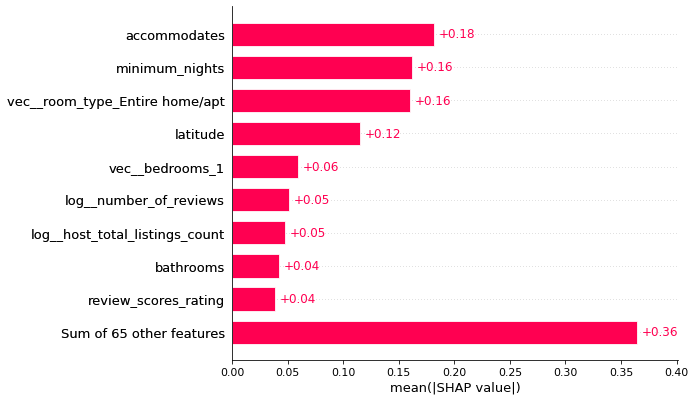

In [58]:
shap.plots.bar(shap_values=shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


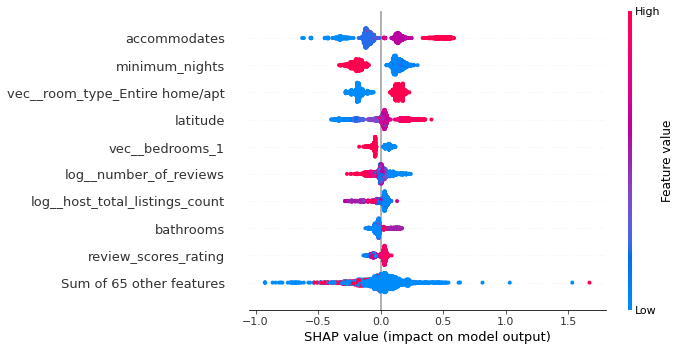

In [59]:
shap.plots.beeswarm(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


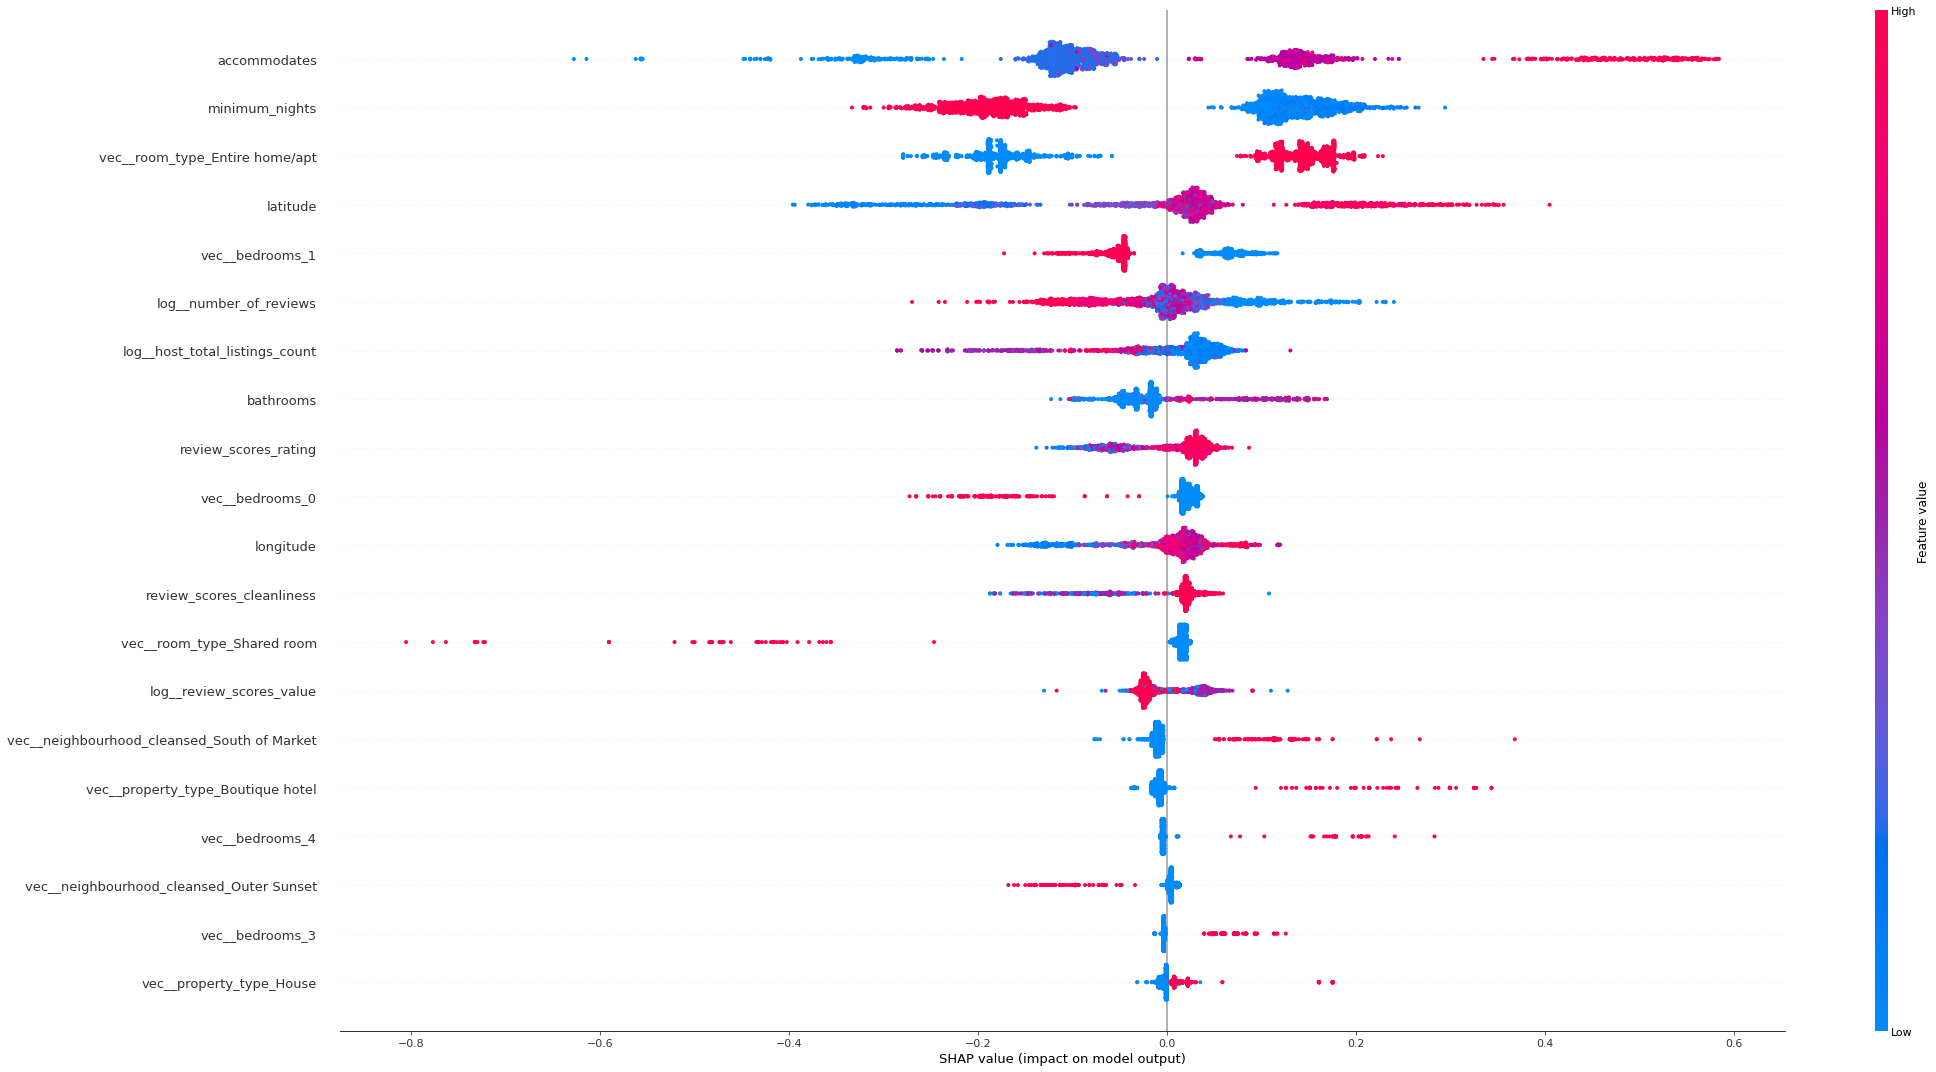

In [60]:
plt_shap = shap.summary_plot(
    shap_values=shap_values, #Use Shap values array
    features=X, # Use training set features
    feature_names=xgb_feature_cols, #Use column names
    show=True,
    plot_size=(30,15),
)